In [1]:
!pip install opencv-python
!pip install opencv-python-headless

     |████████████████████████████████| 60.9 MB 27.4 MB/s eta 0:00:01    |▎                               | 512 kB 19.0 MB/s eta 0:00:04     |█                               | 1.7 MB 19.0 MB/s eta 0:00:04
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 48.3 MB 19.5 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import pandas as pd
from keras.applications.vgg16 import VGG16 as vgg16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from math import floor
import numpy as np
import cv2
from os import listdir
from os.path import isfile, join
from numpy import expand_dims, array, exp, max
import json
import csv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50 as resnet50
from tensorflow.keras.applications.inception_v3 import InceptionV3 as inception
from tensorflow.keras.applications.densenet import DenseNet169 as densenet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout,GlobalAveragePooling2D,Flatten
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib
import matplotlib.pyplot as plt
import os
import scipy
from scipy import ndimage
import imageio
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
import random

In [5]:
print(tf.__version__)

2.4.1


In [3]:
# set the model hyper parameters
BATCH_SIZE = 8
# set the image size to fit the resnet model for lower overfitting
IMG_SIZE = (224, 224)

In [4]:
#@train_df = pd.read_csv("files/test_correlation_above_glcm.csv")
#train_df2 = pd.read_csv("files/test_correlation_below_glcm.csv")

train_df = pd.read_csv("files/caltech256/glcm/compared/caltech256_test_energy_above_glcm_above.csv")
train_df2 = pd.read_csv("files/caltech256/glcm/compared/caltech256_test_energy_above_glcm_below.csv")

In [19]:
train_df3 = pd.read_csv("files/caltech256/glcm/compared/caltech256_test_homogeneity_above_glcm_above.csv")
train_df4 = pd.read_csv("files/caltech256/glcm/compared/caltech256_test_homogeneity_above_glcm_below.csv")

In [20]:
print(train_df2)

NameError: name 'train_df2' is not defined

In [21]:
train_dataset_gen = ImageDataGenerator(rescale=1. / 255,
        shear_range=0.2,
        zoom_range=0.15, 
        brightness_range=[0.7, 1.4],
        vertical_flip=True,  
        horizontal_flip=True,
        rotation_range=15, 
        
        
        width_shift_range=0.1, 
        height_shift_range=0.1,
        validation_split=0.2,
        fill_mode='nearest')

In [22]:
training_dataset = train_dataset_gen.flow_from_dataframe(dataframe=train_df3,
                                                         directory="Caltech256/caltech256data/256_ObjectCategories/",
                                                         shuffle=True,
                                                         x_col="file",
                                                         y_col="label",
                                                         batch_size=BATCH_SIZE,
                                                         target_size=IMG_SIZE,
                                                         validate_filenames=False,
                                                         class_mode="categorical",
                                                         subset="training")

training_dataset2 = train_dataset_gen.flow_from_dataframe(dataframe=train_df4,
                                                         directory="Caltech256/caltech256data/256_ObjectCategories/",
                                                         shuffle=True,
                                                         x_col="file",
                                                         y_col="label",
                                                         batch_size=BATCH_SIZE,
                                                         target_size=IMG_SIZE,
                                                         validate_filenames=False,
                                                         class_mode="categorical",
                                                         subset="training")

Found 1229 non-validated image filenames belonging to 39 classes.
Found 2372 non-validated image filenames belonging to 39 classes.


In [23]:
model_name = vgg16
input_t =(224, 224, 3)
#model = tf.keras.applications.DenseNet169(weights = 'imagenet', include_top = False, input_shape = input_t)

model_t = model_name(include_top=False,
                   weights="imagenet",
                   input_shape = input_t)

model_t2 = model_name(include_top=False,
                   weights="imagenet",
                   input_shape = input_t)

In [24]:
model_t.trainable = False
model_t2.trainable = False

In [25]:
#finetune by removeing the last layer
#for layer in model_t.layers[:-2]:
    #layer.trainable = False

In [26]:
#model classifier topup
#reg=0.001

model = Sequential()
model.add(model_t)
model.add(Flatten())
#model.add(layers.BatchNormalization())
#model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2(reg)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(39, activation='softmax'))


model2 = Sequential()
model2.add(model_t2)
model2.add(Flatten())
#model.add(layers.BatchNormalization())
#model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2(reg)))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.Dropout(0.5))

model2.add(layers.Dense(39, activation='softmax'))

In [27]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

In [28]:
model.compile(optimizer=optimizers.SGD(learning_rate=0.001), loss=losses.categorical_crossentropy, metrics=['accuracy','Precision','Recall'])
history = model.fit(training_dataset, batch_size=4, shuffle=True, epochs=100, verbose=1)

model2.compile(optimizer=optimizers.SGD(learning_rate=0.001), loss=losses.categorical_crossentropy, metrics=['accuracy','Precision','Recall'])
history2 = model2.fit(training_dataset2, batch_size=4, shuffle=True, epochs=100, verbose=1)


Epoch 1/100
154/154 [==============================] - 21s 128ms/step - loss: 3.6731 - accuracy: 0.1087 - precision: 0.4812 - recall: 0.0113
Epoch 2/100
154/154 [==============================] - 19s 125ms/step - loss: 2.6837 - accuracy: 0.3033 - precision: 0.8861 - recall: 0.0698
Epoch 3/100
154/154 [==============================] - 19s 124ms/step - loss: 2.5323 - accuracy: 0.3504 - precision: 0.8719 - recall: 0.1046
Epoch 4/100
154/154 [==============================] - 19s 124ms/step - loss: 2.3455 - accuracy: 0.4085 - precision: 0.8945 - recall: 0.1195
Epoch 5/100
154/154 [==============================] - 19s 125ms/step - loss: 2.3111 - accuracy: 0.4101 - precision: 0.9602 - recall: 0.1343
Epoch 6/100
154/154 [==============================] - 19s 124ms/step - loss: 2.1495 - accuracy: 0.4670 - precision: 0.9104 - recall: 0.1571
Epoch 7/100
154/154 [==============================] - 19s 125ms/step - loss: 2.1537 - accuracy: 0.4581 - precision: 0.8407 - recall: 0.1471
Epoch 8/100
1

297/297 [==============================] - 37s 124ms/step - loss: 1.6657 - accuracy: 0.5948 - precision: 0.9110 - recall: 0.2577
Epoch 19/100
297/297 [==============================] - 37s 124ms/step - loss: 1.6003 - accuracy: 0.6189 - precision: 0.9253 - recall: 0.2928
Epoch 20/100
297/297 [==============================] - 37s 124ms/step - loss: 1.6034 - accuracy: 0.5959 - precision: 0.9196 - recall: 0.2778
Epoch 21/100
297/297 [==============================] - 37s 124ms/step - loss: 1.6138 - accuracy: 0.6210 - precision: 0.9285 - recall: 0.2812
Epoch 22/100
297/297 [==============================] - 37s 124ms/step - loss: 1.5261 - accuracy: 0.6229 - precision: 0.9441 - recall: 0.3308
Epoch 23/100
297/297 [==============================] - 37s 125ms/step - loss: 1.5301 - accuracy: 0.6264 - precision: 0.9205 - recall: 0.3075
Epoch 24/100
297/297 [==============================] - 37s 124ms/step - loss: 1.4803 - accuracy: 0.6426 - precision: 0.9261 - recall: 0.3217
Epoch 25/100
297/29

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


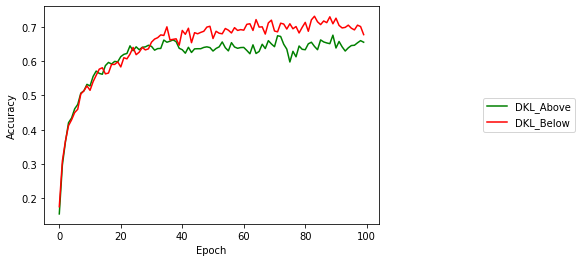

In [30]:
fig1 = plt.figure()

plt.plot(history2.history['accuracy'], color='g')
plt.plot(history.history['accuracy'], color='r')
#plt.title('Caltech 256')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['DKL_Above','DKL_Below'], loc="center right", bbox_to_anchor=(1.6, 0.5))
fig1.savefig('vggGLCM_homogeneity_DKL_accuracy_CALTECH256_fl454565465.eps',  dpi=1000, format="eps", bbox_inches="tight") 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


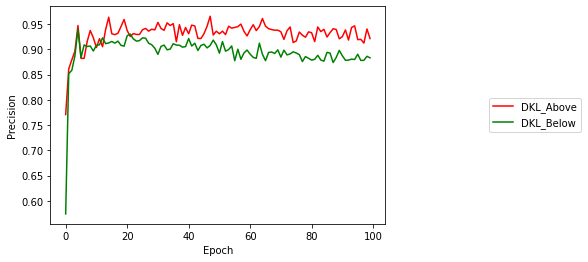

In [32]:
fig1 = plt.figure()
plt.plot(history.history['precision'], color='r')
plt.plot(history2.history['precision'], color='g')
#plt.title('Caltech 256')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['DKL_Above','DKL_Below'], loc="center right", bbox_to_anchor=(1.6, 0.5))
fig1.savefig('vggGLCM_homogeneity_DKL_precision_CALTECH256_f177876768787.eps',  dpi=1000, format="eps", bbox_inches="tight") 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


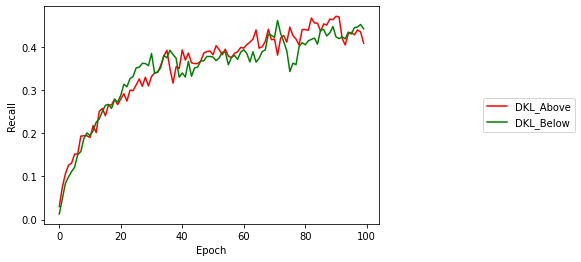

In [33]:
fig1 = plt.figure()
plt.plot(history.history['recall'], color='r')
plt.plot(history2.history['recall'], color='g')
#plt.title('Caltech 256')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['DKL_Above','DKL_Below'], loc="center right", bbox_to_anchor=(1.6, 0.5))
fig1.savefig('GLCM_homogeneity_DKL_recall_CALTECH256_f123443243.eps',  dpi=1000, format="eps", bbox_inches="tight") 